In [2]:
#necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split


# Image manipulation.
import PIL.Image
import cv2
from IPython.display import display
#from resizeimage import resizeimage


# one hot encoding



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Panda
import pandas as pd

#Open a Zip File
from zipfile import ZipFile
from io import BytesIO

#check tensorflow version
tf.__version__

'1.8.0'

In [3]:
#We unzip the train and test zip file
archive_train = ZipFile("/home/hitesh/Downloads/capstone/train.zip", 'r')


#This line shows the 5 first image name of the train database
archive_train.namelist()[0:5]

#This line shows the number of images in the train database
len(archive_train.namelist()[:])-1 #we must remove the 1st value

10222

In [29]:
def DataBase_creator(archivezip, nwigth, nheight, save_name):
    #We choose the archive (zip file) + the new wigth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwigth, nheight,3) #nwigth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwigth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #we save the newly created data base
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [30]:
image_resize = 60

In [4]:
DataBase_creator(archivezip = archive_train, nwigth = image_resize, nheight = image_resize , save_name = "train")

NameError: name 'DataBase_creator' is not defined

In [31]:
#load TRAIN
train = pickle.load( open( "train.p", "rb" ) )
train.shape


(10222, 60, 60, 3)

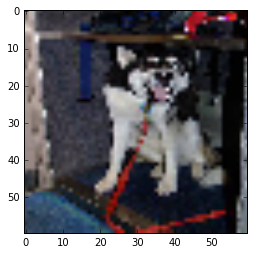

In [32]:
#let's check one image from the train data base
lum_img = train[155,:,:,:]
plt.imshow(lum_img)
plt.show()

In [33]:
######Upload the zip (input data base)########
labels_raw = pd.read_csv("/home/hitesh/Downloads/capstone/labels.csv", header=0, sep=',', quotechar='"')

#Check 5 random values
labels_raw.sample(5)

,id,breed
1440,23fae27f01d6a6dce68a8235f4712f05,scotch_terrier
2370,3b12048d020041c45c17515607f11ffc,french_bulldog
3120,4d182297da4054905b1de22d440b50da,pug
5302,859deae5a4eb97d0d32c94eb936228ed,scottish_deerhound
4188,68169c9827bd02d335fbccdfcf26bb04,ibizan_hound


In [34]:
labels_raw.shape

(10222, 2)

In [35]:
Nber_of_breeds = 10

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 10 main breeds : (1141,)
- The shape of train_filtered dataset is : (1141, 60, 60, 3)


In [36]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(1141, 1)

In [37]:

values = labels

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels_encoded = onehot_encoder.fit_transform(integer_encoded)
print(labels_encoded)
# invert first example
#inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


/home/hitesh/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
##CNN model
num_validation = 0.20
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_encoded, test_size=num_validation, random_state=6)
X_train.shape



(912, 60, 60, 3)

In [39]:
#Our images are 60 pixels in each dimension.
img_size = image_resize

# Number of colour channels for the images: 3
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Image Shape
img_shape = (img_size, img_size, num_channels)

# Number of classes : 120 breeds
num_classes = Nber_of_breeds

In [109]:
img_shape

(60, 60, 3)

In [40]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
#outputs random value from a truncated normal distribution

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
#outputs the constant value 0.05

In [41]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_batchnorm = True, # Use Batch norm
                   use_pooling=True,
                   use_dropout=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
   
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # Conv layer
   
  
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    

    # A bias-value is added to each filter-channel.
    layer += biases
    
    # Batch_normalization
    if use_batchnorm:
        
        layer = tf.layers.batch_normalization(layer,epsilon= 0.0001)

    
    # Rectified Linear Unit (ReLU).
    
    layer = tf.nn.relu(layer)
    
    # Use pooling to down-sample the image resolution?
    if use_pooling:
      
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        
    
    
        

    # Dropout layer
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)

 

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [42]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


In [43]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 use_dropout=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [44]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [45]:
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 32         # There are 8 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64      # There are 16 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128      # There are 16 of these filters.

# Convolutional layer 4
filter_size4 = 2
num_filters4 = 256

# Fully-connected layer.
fc_size = 500

In [46]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_batchnorm = True,
                   use_pooling=False,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_batchnorm = False,
                   use_pooling=False,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_batchnorm = False,
                   use_pooling= False,
                   use_dropout= False)

layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_batchnorm = False,
                   use_pooling= True,
                   use_dropout=True)







In [47]:
layer_flat, num_features = flatten_layer(layer_conv4)

In [48]:
#Train
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_5:0' shape=(?, 10) dtype=float32>

In [49]:
#Prediction :
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [51]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
session = tf.Session()

def init_variables():
    session.run(tf.global_variables_initializer())

In [53]:
batch_size = 128

#function next_batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [54]:


def optimize(num_iterations, X):
    global total_iterations
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    for i in range(num_iterations):
            total_iterations += 1
            # batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.3,
                               keep_prob_fc : 0.4}
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # Run the optimizer using this batch of training data.
           
            
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # Print status every X iterations.
            if (total_iterations % X == 0) or (i ==(num_iterations -1)):
            # Calculate the accuracy on the training-set.
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(total_iterations, acc_train, acc_validation))
                
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [55]:
init_variables()
total_iterations = 0


In [56]:
epoch = X_train.shape[0]/batch_size
epoch = int(epoch)
epoch

7

Iteration:      1, Training Accuracy:  12.5%, Validation Accuracy:   7.9%
Iteration:      2, Training Accuracy:  10.9%, Validation Accuracy:  11.8%
Iteration:      3, Training Accuracy:  10.2%, Validation Accuracy:  12.2%
Iteration:      4, Training Accuracy:   9.4%, Validation Accuracy:  12.2%
Iteration:      5, Training Accuracy:  13.3%, Validation Accuracy:  10.9%
Iteration:      6, Training Accuracy:  10.9%, Validation Accuracy:   7.9%
Iteration:      7, Training Accuracy:  10.2%, Validation Accuracy:   9.6%
Time usage: 0:01:19


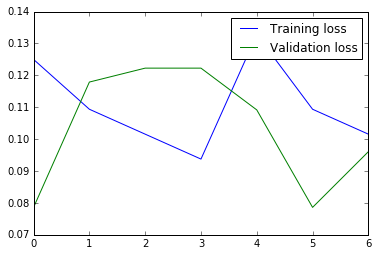

In [57]:
##

optimize(num_iterations=epoch, X=1)

In [58]:
def plot_confusion_matrix(data_pred_cls,data_predicted_cls):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
  
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_pred_cls,
                          y_pred=data_predicted_cls)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

   
    plt.show()

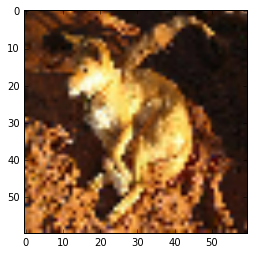

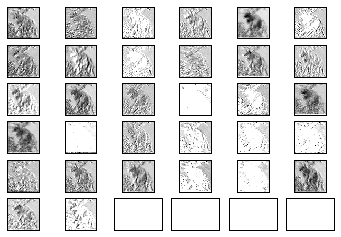

In [61]:
#Visualing the convolutional layers

%matplotlib inline
image = train[1,:,:,:]
plt.imshow(image)
feed_dict = {x: [image],
                keep_prob_conv : 1,
                keep_prob_fc : 1}
values = session.run(layer_conv1, feed_dict=feed_dict)
values.shape
num_filters = values.shape[3]

num_grids = int(math.ceil(math.sqrt(num_filters)))


fig, axes = plt.subplots(num_grids, num_grids)

for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
plt.show()





In [64]:
values.shape

(1, 60, 60, 32)

In [59]:
output= np.empty([0,1])
for i in y_validation:
    a = i.argmax()
    output = np.append(output,a)
output.shape

(229,)

In [62]:
feed_dict_validation = {x: X_validation,
                    y_true: y_validation,
                    keep_prob_conv : 1,
                    keep_prob_fc : 1}
df_validation_Predicted_cls = session.run(y_pred_cls, feed_dict=feed_dict_validation)

[[ 0  0  0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0  0  0  1 32]
 [ 0  0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0 15]
 [ 0  0  0  0  2  0  0  0  0 26]
 [ 0  0  0  0  0  0  0  0  0 22]]


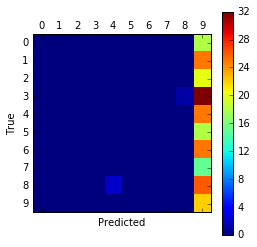

In [63]:
###confusion matrix

plot_confusion_matrix(output,df_validation_Predicted_cls)